In [2]:
from cvxpy import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [4]:
def nuclear_norm_solve(A, mask, mu=1.0):
  """
  Solve using a nuclear norm approach, using CVXPY.
  [ Candes and Recht, 2009 ]

  Parameters:
  -----------
  A : m x n array
    matrix we want to complete

  mask : m x n array
    matrix with entries zero (if missing) or one (if present)

  mu : float
    hyper-parameter controlling trade-off between nuclear norm and square loss

  Returns:
  --------
  X: m x n array
    completed matrix
  """
  X = Variable(shape=A.shape)
  objective = Minimize(mu * norm(X, "nuc") +
                       sum_squares(multiply(mask, X-A)))
  problem = Problem(objective, [])
  problem.solve(solver=SCS)
  return X.value

In [5]:
def calc_unobserved_rmse(U, V, A_hat, mask):
  """
  Calculate RMSE on all unobserved entries in mask, for true matrix UV^T.

  Parameters
  ----------
  U : m x k array
    true factor of matrix

  V : n x k array
    true factor of matrix

  A_hat : m x n array
    estimated matrix

  mask : m x n array
    matrix with entries zero (if missing) or one (if present)

  Returns:
  --------
  rmse : float
    root mean squared error over all unobserved entries
  """
  pred = np.multiply(A_hat, (1 - mask))
  truth = np.multiply(np.dot(U, V.T), (1 - mask))
  cnt = np.sum(1 - mask)
  return (np.linalg.norm(pred - truth, "fro") ** 2 / cnt) ** 0.5

In [6]:
def make_plots(U,V,R,R_hat,mask,noise):
    fig, ((ax1, on1, ax2), (ax3, no1, ax4)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(12, 6))

    p = ax1.imshow(np.dot(U, V.T), cmap=plt.get_cmap('winter'), interpolation='nearest')
    ax1.set_title('Original')
    fig.colorbar(p, ax=ax1)
    
    p = on1.imshow(R, cmap=plt.get_cmap('winter'), interpolation='nearest')
    on1.set_title('Original with noise')
    fig.colorbar(p, ax=on1)
    
    p = ax2.imshow(R_hat, cmap=plt.get_cmap('winter'), interpolation='nearest')
    ax2.set_title('Recovered')
    fig.colorbar(p, ax=ax2)
    
    p = ax3.imshow(mask, cmap=plt.get_cmap('summer'), interpolation='nearest')
    fig.colorbar(p, ax=ax3)
    ax3.set_title('Mask')
    
    p = no1.imshow(noise, cmap=plt.get_cmap('winter'), interpolation='nearest')
    no1.set_title('Noise')
    fig.colorbar(p, ax=no1)
    
    p = ax4.imshow(np.abs(R-R_hat)/R, cmap=plt.get_cmap('hot'), interpolation='nearest', vmin=0, vmax=1)
    ax4.set_title('% error')
    fig.colorbar(p, ax=ax4)

    print("RMSE:", calc_unobserved_rmse(U, V, R_hat, mask))

In [17]:
def plot_density(x,y,xlim=[0,1.5e-5],ylim=[0,1]):
    x = np.array(x)
    y = np.array(y)

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('std dev error')
    ax.set_ylabel('rmse')
    plt.show()

C:\Users\root\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\root\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


RMSE: 0.0020467874754558813


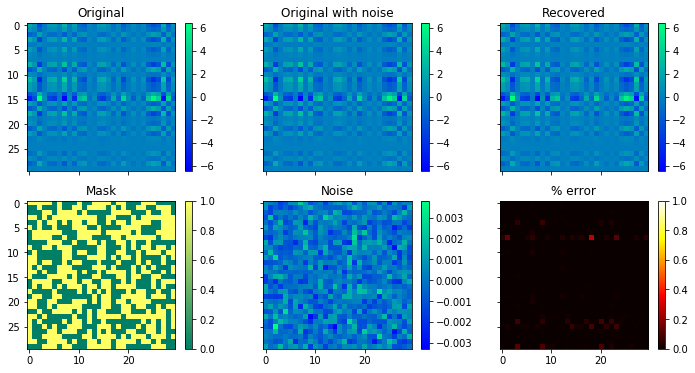

In [8]:
p = 0.5
n = 30
rank = 1
sigma = 1e-3

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
noise = sigma * np.random.randn(n, n)
R = noise + np.dot(U, V.T)
#R = np.dot(U, V.T)

lam = 5*sigma*np.sqrt(n*p)        
mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])
R_hat = nuclear_norm_solve(R, mask, lam)

make_plots(U,V,R,R_hat,mask,noise)

In [23]:
sigmas = []
rmsers = []

p = 0.5
n = 100
rank = 1

sigma_max = 1.5e-05
sigma_samples = 50
samples_per_sigma = 10

for i in range(sigma_samples):
    print(i)
    for j in range(samples_per_sigma):
        
        sigma = i*sigma_max/sigma_samples

        U = np.random.randn(n, rank)
        V = np.random.randn(n, rank)
        R = sigma * np.random.randn(n, n) + np.dot(U, V.T)

        lam = 5*sigma*np.sqrt(n*p)
        
        mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])
        R_hat = nuclear_norm_solve(R, mask, lam)

        if R_hat is not None:
            rmse = calc_unobserved_rmse(U, V, R_hat, mask)
            rmsers.append(rmse)
            sigmas.append(sigma)
        else:
            print('fail')

plot_density(sigmas,rmsers,[2e-6,1.5e-5],[0,0.00005])

0


C:\Users\root\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\root\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


1
fail
2
fail
3
fail
fail
fail
fail
4
fail
5
fail
fail
fail
6
fail
fail
7
8
fail
fail
9
fail
fail
10
fail
11
fail
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

Why is the rmse smaller for larger sigmas? (And then it grows again)
Strange!

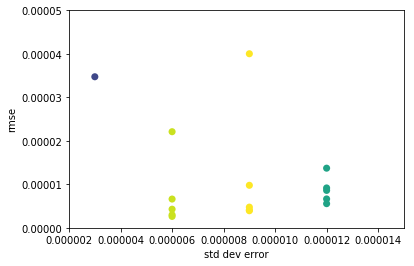

In [22]:
plot_density(sigmas,rmsers,[2e-6,1.5e-5],[0,0.00005])

In [ ]:
plot_density(sigmas,rmsers,[2e-6,1.5e-5],[0,0.00005])